In [1]:
# Standard imports wo wotk with data, graphs, APIs, etc.

# Compatibility with Python 3
from __future__ import print_function, division

import sys

import pylab as pl
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import requests
import urllib2
import urllib
import ast
from cStringIO import StringIO

# from get_jsonparsed_data import get_jsonparsed_data
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.interpolate import *
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
import zipfile

from geopandas import GeoDataFrame
# Be sure to use the latest geopandas version from the anaconda distro
# conda install -c conda-forge geopandas

import pysal as ps
from fiona.crs import from_epsg
import matplotlib.colors as mcolors
import operator
from matplotlib.colors import ListedColormap    
from IPython.display import Image
from IPython.core.display import HTML

import shapely as sy
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from time import sleep

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
# update the rcParams object
pl.rcParams.update(data)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Program Files\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Program Files\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['griddata', 'Polygon', 'insert', 'polyint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Load the datasets for cooling towers, violations and hearings

# Cooling Towers
filePath = "data/Cooling Tower.geojson"
gdfCoolingTowers = GeoDataFrame.from_file(filePath)

# NYC Borough Boundaries.geojson
filePath = "data/Borough Boundaries.geojson"
gdfNYCBoroughs = GeoDataFrame.from_file(filePath)

# Hearings 
filePath = "data/Cooling_Tower_Hearings.csv"
dfCoolingTowerHearings = pd.DataFrame.from_csv(filePath)

# Cooling towers violations
filePath = "data/ECB_Notice_of_Violations__Cooling_towers_.csv"
dfCoolingTowersViolations = pd.DataFrame.from_csv(filePath)

# Cooling towers violations BBL
filePath = "data/Violation_CoolingTowers_BBL.csv"
dfCoolingTowersViolationsBBL = pd.DataFrame.from_csv(filePath)


# Convert the coordinates to lat/lon
#gdfCoolingTowers = gdfCoolingTowers.to_crs(epsg=4326)

In [6]:
# Print the lenght of the datasetv
# (How many registered cooling towers!?)

len(gdfCoolingTowers.index)

3204

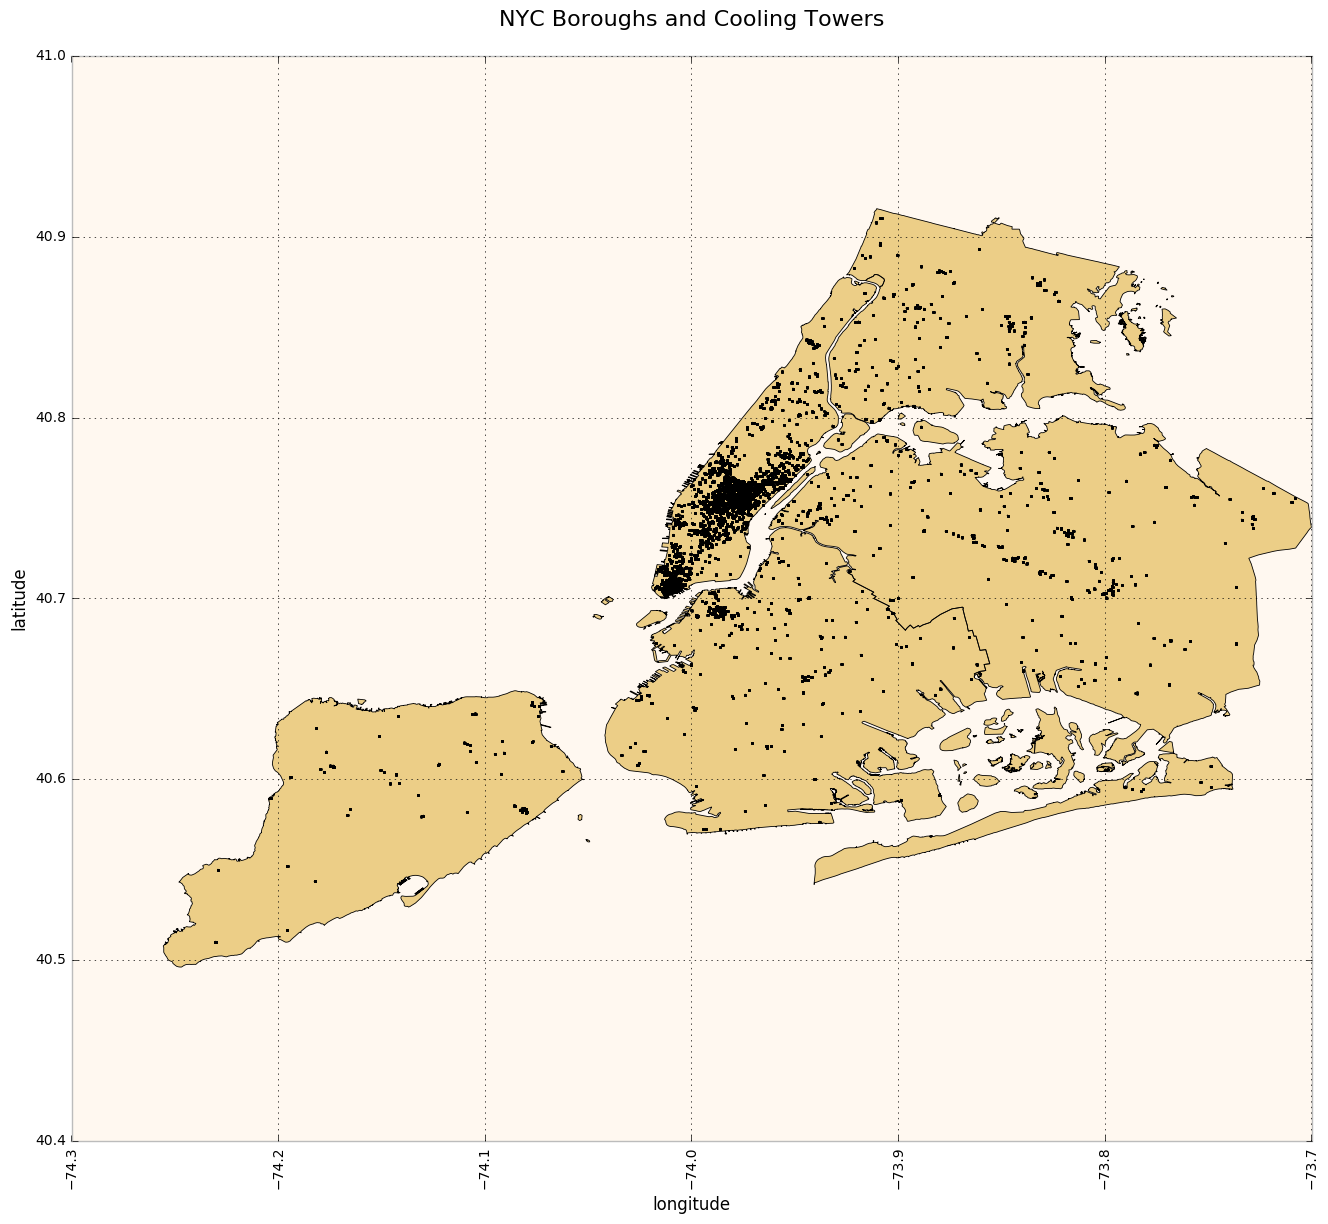

In [8]:
# Exploring the towers shapes
# Plotting NYC Boroughs and Towers

f, ax = pl.subplots(figsize=(16,14))

gdfNYCBoroughs.plot(linewidth = 0.6, color = 'goldenrod',alpha = 0.5, ax = ax)
gdfCoolingTowers.plot(marker='o', markersize=1.5, linewidth = 1, 
                      alpha = 0.5,color = 'r', ax = ax)

pl.xlabel('longitude')
pl.ylabel('latitude')
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
pl.title("NYC Boroughs and Cooling Towers\n", size=16)

In [12]:
# Filter Violation Details to obtain Failure to register
# There are 17 different violation details for failures to register

#28-317.3 FAILURE TO REGISTER COOLING TOWER.REM:COMPLY W CODE.
#SEC. 287-317.3 FAILURE TO REGISTER COOLING TOWER. REMEDY: COMPLY W CODE.
#28-317.3 FAILURE TO REGISTER COOLING TOWER. RMDY: COMPLY W CODE.
#SEC. 28-317.3 FAILURE TO REGISTER COOLING TOWER. REMEDY: COMPLY W CODE
#28-317.3 FAILURE TO REGISTER COOLING TOWER.REM:COMPLY W CODE.
#28-317.3 FAILURE TO REGISTER COOLING TOWER.REM:COMPLY WITH CODE.
#28-317.3,FAILURE TO REGISTER COOLING TOWER.REM:COMPLY W CODE
#28-317.3 FAILURE TO REGISTER COOLING TOWER.REM:COMPLY WITH CODE
#28-317.3 FAILURE TO REGISTER COOLING TOWER.REM COMPLY W CODE.
#28-371.3 FAILURE TO REGISTER COOLING TOWER.REM:COMPLY W CODE.
#28.317.3 FAILURE TO REGISTER COOLING TOWER.REM:COMPLY W CODE.
#FAILURE TO REGISTER COOLING TOWER.REM:COMPLY WITH CODE
#28-317.3 FAILURE TO REGISTER COOLING TOWER.REM COMPLY W CODE
#28-317.3 FAILURE TO REGISTER COOLING TOWER.REM:COMPLY CODE.
#FAILURE TO REGISTER COOLING TOWER; REMEDY: COMPLY W CODE
#28-317.3 FAILURE TO REGISTER COOLING TOWER. RMDY:COMPLY W CODE
#SEC. 28-317.3 FAILURE TO REGISTER COOLING TOWER. REMEDY: COMPLY W CODE.

dfCoolingTowersRegistrationViolations = \
dfCoolingTowersViolations[dfCoolingTowersViolations['Violation Details'].str.contains("FAILURE TO REGISTER")==True]

#df[df['A'].str.contains("Hello|Britain")==True]



In [16]:
dfCoolingTowersRegistrationViolations['Violation Details'].index

Index([u'037000217L', u'037000485H', u'037000190K', u'037000195J',
       u'037000256Y', u'037000189N', u'037000243P', u'037000198P',
       u'037000241L', u'037000270K',
       ...
       u'037000337X', u'037000338H', u'037000384Z', u'037000254K',
       u'037000345X', u'037000367R', u'037000402N', u'037000171P',
       u'037000191M', u'037000233L'],
      dtype='object', name=u'Ticket Number', length=456)

In [4]:
dfCoolingTowersViolationsBBL

,Ticket Number,Violation Date,Violation Time,Issuing Agency,Respondent Last Name,Respondent First Name,Balance Due,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),...,Charge #8: Infraction Amount,Charge #9: Code,Charge #9: Code Section,Charge #9: Code Description,Charge #9: Infraction Amount,Charge #10: Code,Charge #10: Code Section,Charge #10: Code Description,Charge #10: Infraction Amount,BBL
0,070001758P,04/12/2006,NaN,LANDMARKS PRESERVATION,"THOMAS CARPENTER, ASST.","DIR. ENG., ABC TV",NaN,1,1118.0,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1011180052
1,037000217L,09/21/2015,08:50:00,DEPT. OF BUILDINGS,"VW CREDIT,INC",NaN,$0.00,1,1084.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1010840001
2,037000485H,09/21/2015,05:00:00,DEPT. OF BUILDINGS,FEDERATED DEPT STORES INC.,NaN,$4000.00,5,2400.0,118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5024000118
3,037000190K,09/21/2015,12:38:00,DEPT. OF BUILDINGS,ABACUS FEDERAL SV BK,NaN,$0.00,1,92.0,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000920024
4,037000195J,09/21/2015,05:15:00,DEPT. OF BUILDINGS,SLOANE BROADWAY LLC,NaN,$0.00,1,483.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1004830007
5,037000256Y,09/21/2015,12:55:00,DEPT. OF BUILDINGS,77 BLEECKER ST CORP,NaN,$0.00,1,532.0,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1005320020
6,037000189N,09/21/2015,01:10:00,DEPT. OF BUILDINGS,"ARC NYC 123WILLIAM,LLC",NaN,$4000.00,1,78.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000780004
7,037000243P,09/21/2015,05:40:00,DEPT. OF BUILDINGS,GUNTHER BLDG 1873 CO,NaN,$0.00,1,475.0,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1004750046
8,037000198P,09/21/2015,03:40:00,DEPT. OF BUILDINGS,NEW YORK UNIVERSITY,NaN,$0.00,1,548.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1005480004
9,037000241L,09/21/2015,00:00:00,DEPT. OF BUILDINGS,MF ASSOCIATES OF NEW YORK LLC,NaN,$0.00,1,1541.0,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1015410021
